In [1]:
import cira 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from os.path import exists

cira.auth.KEY_FILE = "../alpc_key.json"
assert cira.auth.check_keys(), "the set keys dose not work"

SYMBOL = "AMZN" # MDRX is shortable 
SYM_HIST_FILE = f'./{SYMBOL.replace("/", "_")}.csv'

stk = cira.Stock(SYMBOL)

if not exists(SYM_HIST_FILE): # chacheing historical data  
    start = datetime(2015, 5, 1)
    end = datetime.now().date()
    stk.save_historical_data(SYM_HIST_FILE, start, end)

data = stk.load_historical_data(SYM_HIST_FILE)
data = data.drop(columns=["symbol"])
data.head()

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2016-01-04 05:00:00+00:00,32.81,32.89,31.38,31.85,192327900.0,137283.0,31.97
2016-01-05 05:00:00+00:00,32.34,32.35,31.38,31.69,119738940.0,72594.0,31.75
2016-01-06 05:00:00+00:00,31.10,31.99,31.02,31.63,109533180.0,67908.0,31.58
2016-01-07 05:00:00+00:00,31.09,31.50,30.26,30.40,145573100.0,92501.0,30.81
2016-01-08 05:00:00+00:00,30.98,31.21,30.30,30.35,114584160.0,71586.0,30.74


In [2]:
data["target"] = data["close"].shift(-5)
data["target"] = (data["target"] > data["close"]).astype(int)
data.dropna(inplace=True)
data.tail()

,open,high,low,close,volume,trade_count,vwap,target
timestamp,,,,,,,,
2024-04-24 04:00:00+00:00,179.940,180.323,176.18,176.59,34185109.0,405353.0,177.227958,0
2024-04-25 04:00:00+00:00,169.680,173.920,166.32,173.67,49249390.0,618272.0,172.035678,0
2024-04-26 04:00:00+00:00,177.795,180.820,176.13,179.62,43919765.0,478171.0,178.972297,0
2024-04-29 04:00:00+00:00,182.750,183.530,179.39,180.96,54067637.0,592823.0,180.661890,0
2024-04-30 04:00:00+00:00,181.090,182.990,174.80,175.00,94639786.0,852830.0,178.701233,0


In [3]:
# batching data
batch_size = 64
data_len = len(data)
n_batches = data_len // batch_size
batches = []
for b in range(n_batches):
    start = b * batch_size
    end = start + batch_size
    batches.append(data.iloc[start:end])
batches[-1].tail()

,open,high,low,close,volume,trade_count,vwap,target
timestamp,,,,,,,,
2024-02-15 05:00:00+00:00,170.58,171.17,167.59,169.80,49855196.0,521440.0,169.435428,1
2024-02-16 05:00:00+00:00,168.74,170.42,167.17,169.51,48079735.0,467539.0,169.182493,1
2024-02-20 05:00:00+00:00,167.83,168.71,165.74,167.08,41980326.0,478320.0,166.909932,1
2024-02-21 05:00:00+00:00,168.94,170.23,167.14,168.59,44575623.0,466026.0,168.545990,1
2024-02-22 05:00:00+00:00,173.10,174.80,171.77,174.58,55392354.0,547144.0,173.540742,1


In [4]:
len(batches)

32

In [5]:
train_batches = batches[:int(n_batches * 0.8)]
test_batches = batches[int(n_batches * 0.8):]
len(train_batches), len(test_batches)

(25, 7)

In [6]:
import torch

class StockDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
        self.features = data.columns[:-1]
        self.target = data.columns[-1]
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        return torch.tensor(row[self.features].values, dtype=torch.float32), torch.tensor(row[self.target], dtype=torch.float32)

train_dataset = StockDataset(train_batches[0])
train_dataset[0]

(tensor([3.2810e+01, 3.2890e+01, 3.1380e+01, 3.1850e+01, 1.9233e+08, 1.3728e+05,
         3.1970e+01]),
 tensor(0.))

In [7]:

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(StockDataset(test_batches[0]), batch_size=64)

class StockModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(5, 64)
        self.fc2 = torch.nn.Linear(64, 64)
        self.fc3 = torch.nn.Linear(64, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = StockModel()
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [8]:

def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    n = 0
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        n += 1
    return running_loss / n
 

In [9]:
test_data = pd.concat(test_batches)

<Axes: xlabel='timestamp'>

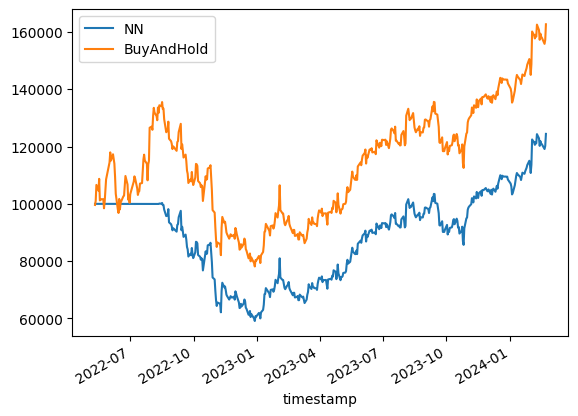

In [10]:
from cira.strategy import back_test_against_buy_and_hold 

class ModelStrategy(cira.strategy.Strategy):
    def __init__(self, model: torch.nn.Module):
        super().__init__(name="NN")
        self.model = model
        self.position_history = []
    
    def iterate(self, feature_data: pd.DataFrame, prices: pd.DataFrame, portfolio: np.ndarray, cash:float)-> np.ndarray:
        feature_tensor = torch.tensor(feature_data[['open', 'high', 'low', 'close', 'volume']].values, dtype=torch.float32)
        if feature_tensor.shape[0] < batch_size:
            return np.array([0])
        feature_tensor = feature_tensor[-batch_size:]
        with torch.no_grad():
            pred = self.model(feature_tensor).numpy()
        p = pred.flatten()
        action = np.where(p > 0, 1, -1)
        position =  np.array([action.sum()])
        self.position_history.append(position)
        return position

        

strat = ModelStrategy(model)
back_test_against_buy_and_hold(strat, test_data, test_data["close"].to_frame(), 100_000).plot()

<Axes: >

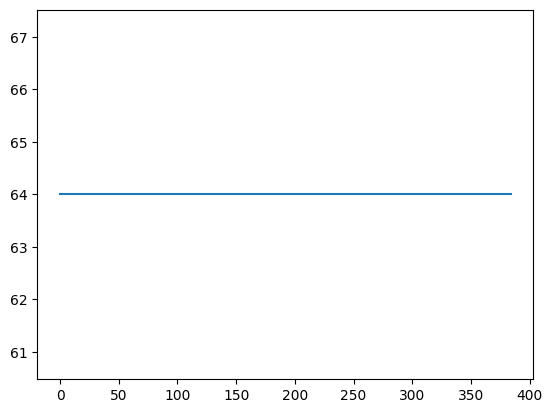

In [11]:
pd.Series(np.array(strat.position_history).flatten().tolist()).plot()

<Axes: xlabel='timestamp'>

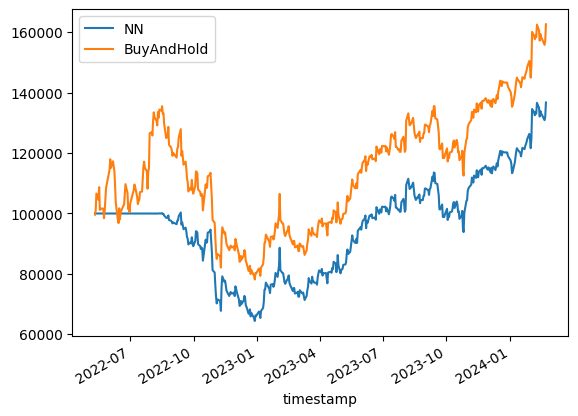

In [12]:
import numpy as np
import torch
import pandas as pd
from cira.strategy import back_test_against_buy_and_hold

class ModelStrategy(cira.strategy.Strategy):
    def __init__(self, model: torch.nn.Module):
        super().__init__(name="NN")
        self.model = model
        self.position_history = []
    
    def iterate(self, feature_data: pd.DataFrame, prices: pd.DataFrame, portfolio: np.ndarray, cash: float) -> np.ndarray:
        self.position_history.append(portfolio[-1])
        feature_tensor = torch.tensor(feature_data[['open', 'high', 'low', 'close', 'volume']].values, dtype=torch.float32)
        if feature_tensor.shape[0] < batch_size:
            return np.array([0])
        feature_tensor = feature_tensor[-batch_size:]
        with torch.no_grad():
            pred = self.model(feature_tensor).numpy()
        confidence = (pred - np.min(pred)) / (np.max(pred) - np.min(pred)).flatten()
        # we want the position to scaled with the confidence
        # so we multiply the confidence by the sign of the prediction
        position = np.array([np.sign(pred.sum()) * confidence.sum()]) 
        return position 


strat = ModelStrategy(model)
back_test_against_buy_and_hold(strat, test_data, test_data["close"].to_frame(), 100_000).plot()

<Axes: >

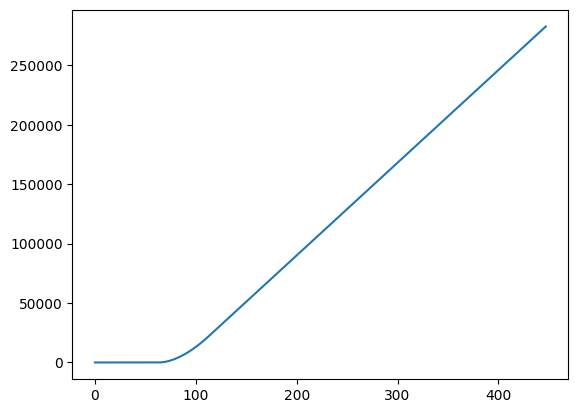

In [13]:

pd.Series(np.array(strat.position_history).flatten().cumsum().tolist()).plot()